In [6]:
import numpy as np
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
from tensorflow_probability import distributions as tfd

from matplotlib import pylab as plt
%matplotlib inline
import scipy.stats

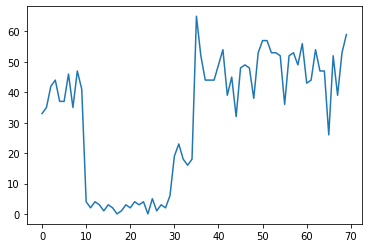

In [7]:
true_rates = [40, 3, 20, 50]
true_durations = [10, 20, 5, 35]

observed_counts = np.concatenate([
  scipy.stats.poisson(rate).rvs(num_steps)
    for (rate, num_steps) in zip(true_rates, true_durations)
]).astype(np.float32)

plt.plot(observed_counts)

In [8]:
num_states = 4 # only the write stall or influence?

initial_state_logits = np.zeros([num_states], dtype=np.float32) # uniform distribution

daily_change_prob = 0.05
transition_probs = daily_change_prob / (num_states-1) * np.ones(
    [num_states, num_states], dtype=np.float32)
np.fill_diagonal(transition_probs,
                 1-daily_change_prob)

print("Initial state logits:\n{}".format(initial_state_logits))
print("Transition matrix:\n{}".format(transition_probs))

Initial state logits:
[0. 0. 0. 0.]
Transition matrix:
[[0.95       0.01666667 0.01666667 0.01666667]
 [0.01666667 0.95       0.01666667 0.01666667]
 [0.01666667 0.01666667 0.95       0.01666667]
 [0.01666667 0.01666667 0.01666667 0.95      ]]


In [9]:
# Define variable to represent the unknown log rates.
trainable_log_rates = tf.Variable(
  np.log(np.mean(observed_counts)) + tf.random.normal([num_states]),
  name='log_rates')

hmm = tfd.HiddenMarkovModel(
  initial_distribution=tfd.Categorical(
      logits=initial_state_logits),
  transition_distribution=tfd.Categorical(probs=transition_probs),
  observation_distribution=tfd.Poisson(log_rate=trainable_log_rates),
  num_steps=len(observed_counts))

<tfp.distributions.HiddenMarkovModel 'HiddenMarkovModel' batch_shape=[] event_shape=[70] dtype=float32>

In [10]:
rate_prior = tfd.LogNormal(5, 5)

def log_prob():
 return (tf.reduce_sum(rate_prior.log_prob(tf.math.exp(trainable_log_rates))) +
         hmm.log_prob(observed_counts))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

@tf.function(autograph=False)
def train_op():
  with tf.GradientTape() as tape:
    neg_log_prob = -log_prob()
  grads = tape.gradient(neg_log_prob, [trainable_log_rates])[0]
  optimizer.apply_gradients([(grads, trainable_log_rates)])
  return neg_log_prob, tf.math.exp(trainable_log_rates)

In [11]:
for step in range(201):
  loss, rates = [t.numpy() for t in train_op()]
  if step % 20 == 0:
    print("step {}: log prob {} rates {}".format(step, -loss, rates))

print("Inferred rates: {}".format(rates))
print("True rates: {}".format(true_rates))

/home/jinghuan/anaconda3/envs/anormally_detection/lib/python3.8/site-packages/tensorflow_probability/python/distributions/hidden_markov_model.py:497: UserWarning: HiddenMarkovModel.log_prob in TFP versions < 0.12.0 had a bug in which the transition model was applied prior to the initial step. This bug has been fixed. You may observe a slight change in behavior.
  warnings.warn(


step 0: log prob -348.2773742675781 rates [ 48.30885   18.007233   8.886295 161.95491 ]
step 20: log prob -243.49267578125 rates [48.505035  18.183558   2.1844065 39.50199  ]
step 40: log prob -243.357177734375 rates [49.104374  18.881117   2.2525961 38.68599  ]
step 60: log prob -242.44801330566406 rates [47.85008   18.486872   2.7531478 39.64565  ]
step 80: log prob -242.3291778564453 rates [48.301178  18.620022   2.5829039 39.68731  ]
step 100: log prob -242.32022094726562 rates [48.199978  18.632305   2.6019478 39.616066 ]
step 120: log prob -242.31996154785156 rates [48.17823  18.632133  2.609801 39.607944]
step 140: log prob -242.31976318359375 rates [48.18812   18.634691   2.6036162 39.630726 ]
step 160: log prob -242.31993103027344 rates [48.191833  18.637375   2.6064463 39.628735 ]
step 180: log prob -242.3199005126953 rates [48.192623 18.637472  2.605349 39.628147]
step 200: log prob -242.31993103027344 rates [48.192867  18.637234   2.6057432 39.628307 ]
Inferred rates: [48.1

For now we got a model, that can detect no order state change points. These steps can tell how the performs of each
state can be. Next step we are trying to know in each explict states

In [12]:
def plot_state_posterior(ax, state_posterior_probs, title):
  ln1 = ax.plot(state_posterior_probs, c='blue', lw=3, label='p(state | counts)')
  ax.set_ylim(0., 1.1)
  ax.set_ylabel('posterior probability')
  ax2 = ax.twinx()
  ln2 = ax2.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
  ax2.set_title(title)
  ax2.set_xlabel("time")
  lns = ln1+ln2
  labs = [l.get_label() for l in lns]
  ax.legend(lns, labs, loc=4)
  ax.grid(True, color='white')
  ax2.grid(False)

posterior_dists = hmm.posterior_marginals(observed_counts)
posterior_probs = posterior_dists.probs_parameter().numpy()

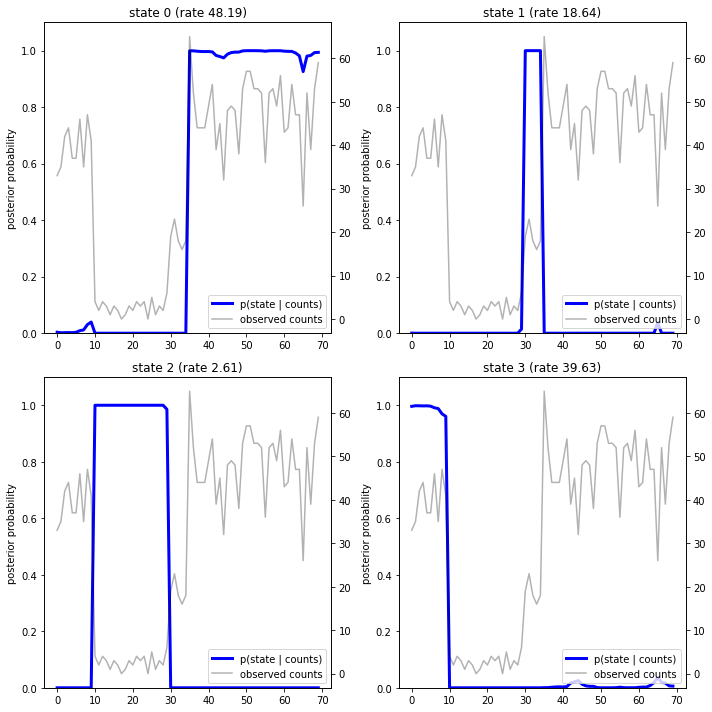

In [13]:
fig = plt.figure(figsize=(10, 10))
plot_state_posterior(fig.add_subplot(2, 2, 1),
                     posterior_probs[:, 0],
                     title="state 0 (rate {:.2f})".format(rates[0]))
plot_state_posterior(fig.add_subplot(2, 2, 2),
                     posterior_probs[:, 1],
                     title="state 1 (rate {:.2f})".format(rates[1]))
plot_state_posterior(fig.add_subplot(2, 2, 3),
                     posterior_probs[:, 2],
                     title="state 2 (rate {:.2f})".format(rates[2]))
plot_state_posterior(fig.add_subplot(2, 2, 4),
                     posterior_probs[:, 3],
                     title="state 3 (rate {:.2f})".format(rates[3]))
plt.tight_layout()

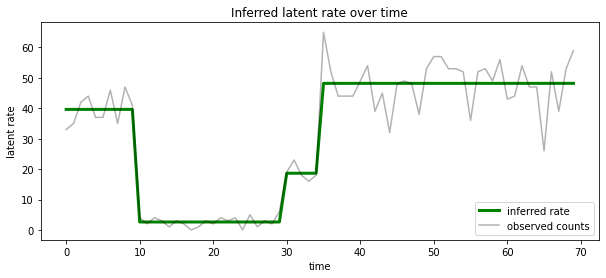

In [14]:
most_probable_states = np.argmax(posterior_probs, axis=1)
most_probable_rates = rates[most_probable_states]
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(most_probable_rates, c='green', lw=3, label='inferred rate')
ax.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
ax.set_ylabel("latent rate")
ax.set_xlabel("time")
ax.set_title("Inferred latent rate over time")
ax.legend(loc=4)

In [15]:
max_num_states = 10

def build_latent_state(num_states, max_num_states, daily_change_prob=0.05):

  # Give probability exp(-100) ~= 0 to states outside of the current model.
  initial_state_logits = -100. * np.ones([max_num_states], dtype=np.float32)
  initial_state_logits[:num_states] = 0.

  # Build a transition matrix that transitions only within the current
  # `num_states` states.
  transition_probs = np.eye(max_num_states, dtype=np.float32)
  if num_states > 1:
    transition_probs[:num_states, :num_states] = (
        daily_change_prob / (num_states-1))
    np.fill_diagonal(transition_probs[:num_states, :num_states],
                     1-daily_change_prob)
  return initial_state_logits, transition_probs

# For each candidate model, build the initial state prior and transition matrix.
batch_initial_state_logits = []
batch_transition_probs = []
for num_states in range(1, max_num_states+1):
  initial_state_logits, transition_probs = build_latent_state(
      num_states=num_states,
      max_num_states=max_num_states)
  batch_initial_state_logits.append(initial_state_logits)
  batch_transition_probs.append(transition_probs)

batch_initial_state_logits = np.array(batch_initial_state_logits)
batch_transition_probs = np.array(batch_transition_probs)
print("Shape of initial_state_logits: {}".format(batch_initial_state_logits.shape))
print("Shape of transition probs: {}".format(batch_transition_probs.shape))
print("Example initial state logits for num_states==3:\n{}".format(batch_initial_state_logits[2, :]))
print("Example transition_probs for num_states==3:\n{}".format(batch_transition_probs[2, :, :]))


Shape of initial_state_logits: (10, 10)
Shape of transition probs: (10, 10, 10)
Example initial state logits for num_states==3:
[   0.    0.    0. -100. -100. -100. -100. -100. -100. -100.]
Example transition_probs for num_states==3:
[[0.95  0.025 0.025 0.    0.    0.    0.    0.    0.    0.   ]
 [0.025 0.95  0.025 0.    0.    0.    0.    0.    0.    0.   ]
 [0.025 0.025 0.95  0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    1.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    1.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    1.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    1.   ]]


In [16]:
trainable_log_rates = tf.Variable(
    (np.log(np.mean(observed_counts)) *
     np.ones([batch_initial_state_logits.shape[0], max_num_states]) +
     tf.random.normal([1, max_num_states])),
     name='log_rates')

hmm = tfd.HiddenMarkovModel(
  initial_distribution=tfd.Categorical(
      logits=batch_initial_state_logits),
  transition_distribution=tfd.Categorical(probs=batch_transition_probs),
  observation_distribution=tfd.Poisson(log_rate=trainable_log_rates),
  num_steps=len(observed_counts))

/home/jinghuan/anaconda3/envs/anormally_detection/lib/python3.8/site-packages/tensorflow_probability/python/distributions/hidden_markov_model.py:497: UserWarning: HiddenMarkovModel.log_prob in TFP versions < 0.12.0 had a bug in which the transition model was applied prior to the initial step. This bug has been fixed. You may observe a slight change in behavior.
  warnings.warn(


step 0: loss [914.8473  922.37756 792.07184 712.0297  686.353   677.89087 686.06134
 636.4911  644.9685  650.7562 ]
step 20: loss [825.01843 279.3102  261.52597 252.66946 255.97595 264.6323  264.7354
 264.80652 272.08188 277.0544 ]
step 40: loss [812.62036 287.3766  249.92961 251.30469 247.77623 263.1938  259.42105
 262.67386 267.98013 275.73114]
step 60: loss [812.80304 279.39877 240.94725 242.7179  246.50012 254.50989 258.7512
 262.2286  265.97046 275.0058 ]
step 80: loss [812.6178  278.55475 241.01614 242.41548 246.33324 254.31744 258.6993
 262.15683 263.3336  274.3044 ]
step 100: loss [812.62054 278.53223 240.92018 242.3259  246.2954  254.20364 258.66757
 262.12558 262.4796  273.41443]
step 120: loss [812.61786 278.51523 240.90994 242.32144 246.27153 254.20213 258.64478
 262.1001  261.56604 273.134  ]
step 140: loss [812.6175  278.51523 240.90993 242.32004 246.24835 254.19998 258.62143
 262.07416 260.84454 273.08737]
step 160: loss [812.6172  278.51462 240.9097  242.31982 246.2248 

Text(0.5, 1.0, 'Model selection on latent states')

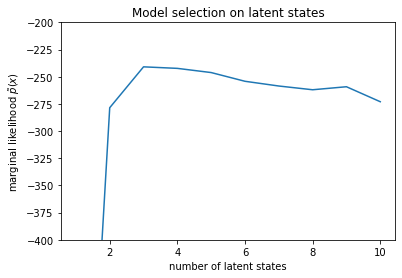

In [17]:
rate_prior = tfd.LogNormal(5, 5)

def log_prob():
  prior_lps = rate_prior.log_prob(tf.math.exp(trainable_log_rates))
  prior_lp = tf.stack(
      [tf.reduce_sum(prior_lps[i, :i+1]) for i in range(max_num_states)])
  return prior_lp + hmm.log_prob(observed_counts)

@tf.function(autograph=False)
def train_op():
  with tf.GradientTape() as tape:
    neg_log_prob = -log_prob()
  grads = tape.gradient(neg_log_prob, [trainable_log_rates])[0]
  optimizer.apply_gradients([(grads, trainable_log_rates)])
  return neg_log_prob, tf.math.exp(trainable_log_rates)

for step in range(201):
  loss, rates =  [t.numpy() for t in train_op()]
  if step % 20 == 0:
    print("step {}: loss {}".format(step, loss))

num_states = np.arange(1, max_num_states+1)
plt.plot(num_states, -loss)
plt.ylim([-400, -200])
plt.ylabel("marginal likelihood $\\tilde{p}(x)$")
plt.xlabel("number of latent states")
plt.title("Model selection on latent states")

rates for 1-state model: [31.843819]
rates for 2-state model: [43.52095    2.6079001]
rates for 3-state model: [46.284832  18.641668   2.6059675]
rates for 4-state model: [39.62848   18.637579   2.6053047 48.193024 ]
rates for 5-state model: [39.617424    2.6069143  18.612007   48.168167    0.67433715]
rates for 6-state model: [48.170788  18.25947   18.260126  39.61347    2.6046233 18.260166 ]
rates for 7-state model: [18.607561   48.15116     2.606268   48.1512      0.62949544 39.526768
 39.526814  ]
rates for 8-state model: [ 2.5643475  48.13994    18.598198   39.521507    2.5643556  39.52168
 48.13983     0.48316333]
rates for 9-state model: [8.1128943e-05 4.8156239e+01 1.8404875e+01 3.9523895e+01 2.5641742e+00
 3.9524033e+01 2.5630240e+00 4.8571026e-01 1.8404821e+01]
rates for 10-state model: [39.51676    2.561421  18.234898  18.23518    2.563266  18.235693
 48.136105   0.4818152 48.136105  39.516808 ]


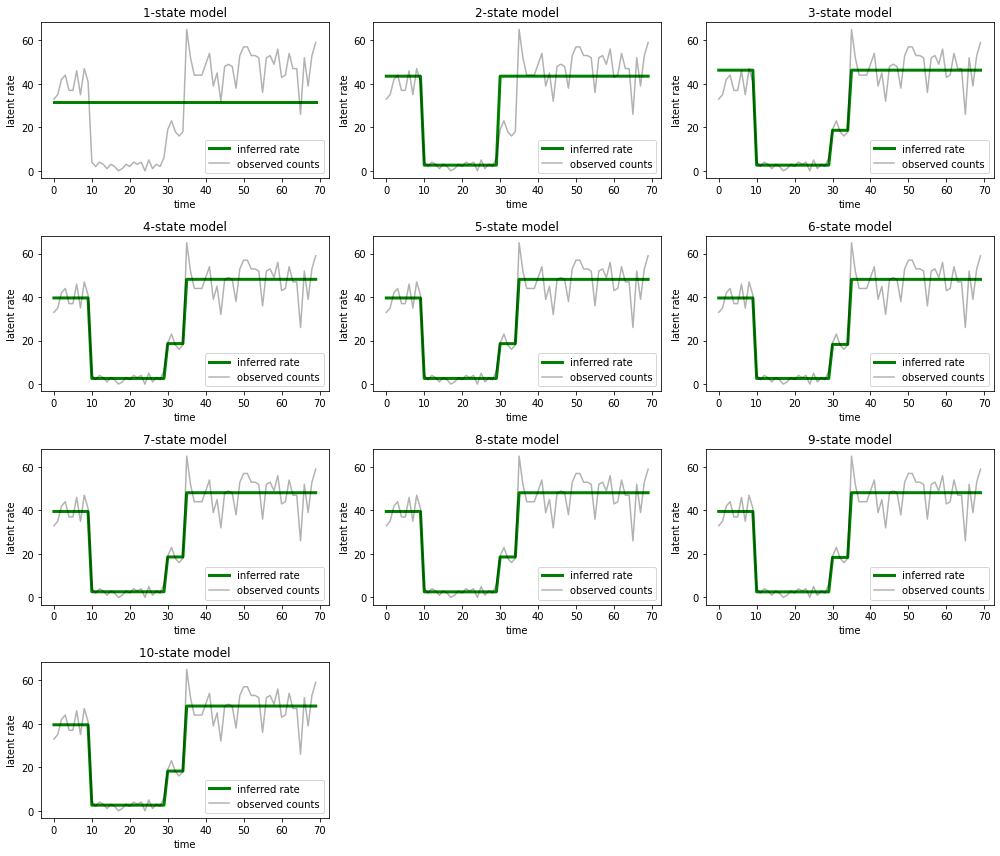

In [18]:
for i, learned_model_rates in enumerate(rates):
  print("rates for {}-state model: {}".format(i+1, learned_model_rates[:i+1]))

posterior_probs = hmm.posterior_marginals(
    observed_counts).probs_parameter().numpy()
most_probable_states = np.argmax(posterior_probs, axis=-1)
fig = plt.figure(figsize=(14, 12))
for i, learned_model_rates in enumerate(rates):
  ax = fig.add_subplot(4, 3, i+1)
  ax.plot(learned_model_rates[most_probable_states[i]], c='green', lw=3, label='inferred rate')
  ax.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
  ax.set_ylabel("latent rate")
  ax.set_xlabel("time")
  ax.set_title("{}-state model".format(i+1))
  ax.legend(loc=4)
plt.tight_layout()

In [21]:
from main import get_log_dirs
from main import get_log_and_std_files
from feature_selection import vectorize_by_compaction_output_level
from main import load_log_and_qps

dirs = get_log_dirs("log_files")

long_gap_write_stall = dirs[0]

stdout_file, LOG_file, report_csv = get_log_and_std_files(long_gap_write_stall)

data_set = load_log_and_qps(LOG_file, report_csv)
bucket_df = vectorize_by_compaction_output_level(data_set)
bucket_df["qps"] = data_set.qps_df["interval_qps"]

1599571593036903


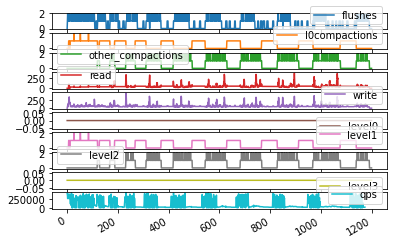

In [26]:
_ = bucket_df.plot(subplots=True)

/home/jinghuan/anaconda3/envs/anormally_detection/lib/python3.8/site-packages/tensorflow_probability/python/distributions/hidden_markov_model.py:497: UserWarning: HiddenMarkovModel.log_prob in TFP versions < 0.12.0 had a bug in which the transition model was applied prior to the initial step. This bug has been fixed. You may observe a slight change in behavior.
  warnings.warn(


step 0: log prob -33965188.0 rates [ 73478.22 282336.16  92261.27 126402.28 102974.56]
step 20: log prob -5269395.0 rates [ 17024.793 352513.88   37967.547 247794.45  128155.75 ]
step 40: log prob -4827836.5 rates [ 11287.943 353881.75   37292.996 239379.2   133550.97 ]
step 60: log prob -4819507.5 rates [ 10732.201 348241.53   35852.594 232788.22  124496.25 ]
step 80: log prob -4811142.0 rates [ 11095.838 346744.97   35997.55  235953.34  130370.82 ]
step 100: log prob -4808555.0 rates [ 11367.323 346645.1    36033.89  235911.05  130113.09 ]
step 120: log prob -4808442.0 rates [ 11446.213 347079.78   36010.84  236008.48  129554.79 ]
step 140: log prob -4808428.0 rates [ 11446.846 347074.16   36017.812 236016.81  129710.69 ]
step 160: log prob -4808425.0 rates [ 11436.948 347033.1    36015.85  236031.44  129637.6  ]
step 180: log prob -4808444.0 rates [ 11435.509 347027.16   36015.164 236045.17  129659.36 ]
step 200: log prob -4808430.0 rates [ 11436.687 347026.47   36014.996 236045.84 

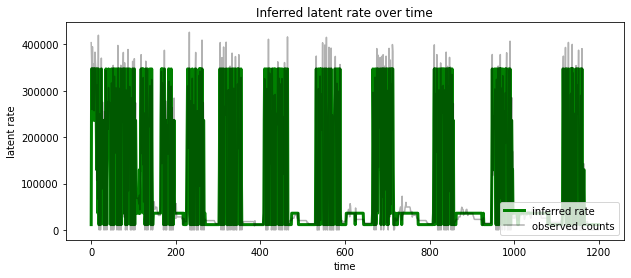

In [88]:
num_states = 5 # memtable filling, flush only, L0 compaction (CPU busy), crowded compaction (disk busy)

initial_state_logits = np.zeros([num_states], dtype=np.float32) # uniform distribution

initial_state_logits[0] = 1.0 # the possiblity of transferring into the Flushing limitation
initial_state_logits

initial_distribution = tfd.Categorical(probs=initial_state_logits)

# transition_probs = np.zeros([num_states,num_states],dtype=np.float32)
# transition_probs[0][1] = 0.9
# transition_probs[1][2] = 0.7
# transition_probs[2][3] = 0.6
# transition_probs[3][2] = 0.4
#
# for i in range(num_states):
#     transition_probs[i][i] = 0.8 # change this to determine how long the states can be

daily_change_prob = 0.05
transition_probs = daily_change_prob / (num_states-1) * np.ones(
    [num_states, num_states], dtype=np.float32)
np.fill_diagonal(transition_probs,
                 1-daily_change_prob)

observed_counts = bucket_df["qps"].fillna(0).tolist()
observed_counts = np.array(observed_counts).astype(np.float32)

transition_distribution = tfd.Categorical(probs=transition_probs)
trainable_log_rates = tf.Variable(
    np.log(np.mean(observed_counts)) + tf.random.normal([num_states]),
    name='log_rates')

hmm = tfd.HiddenMarkovModel(
    initial_distribution=initial_distribution,
    transition_distribution=transition_distribution,
    observation_distribution=tfd.Poisson(log_rate=trainable_log_rates),
    num_steps=len(observed_counts))

rate_prior = tfd.LogNormal(5, 5)
hmm
#
def log_prob():
 return (tf.reduce_sum(rate_prior.log_prob(tf.math.exp(trainable_log_rates))) +
         hmm.log_prob(observed_counts))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
# #
@tf.function(autograph=False)
def train_op():
  with tf.GradientTape() as tape:
    neg_log_prob = -log_prob()
  grads = tape.gradient(neg_log_prob, [trainable_log_rates])[0]
  optimizer.apply_gradients([(grads, trainable_log_rates)])
  return neg_log_prob, tf.math.exp(trainable_log_rates)
#
for step in range(201):
  loss, rates = [t.numpy() for t in train_op()]
  if step % 20 == 0:
    print("step {}: log prob {} rates {}".format(step, -loss, rates))


posterior_dists = hmm.posterior_marginals(observed_counts)
posterior_probs = posterior_dists.probs_parameter().numpy()
most_probable_states = np.argmax(posterior_probs, axis=1)
most_probable_rates = rates[most_probable_states]

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(most_probable_rates, c='green', lw=3, label='inferred rate')
ax.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
ax.set_ylabel("latent rate")
ax.set_xlabel("time")
ax.set_title("Inferred latent rate over time")
ax.legend(loc=4)
plt.savefig("state_guessing.pdf")